# Seoul Bike Trip Duration Prediction

<img src="Features_Description.png" style="float:right;" width="500"/>

### Context
- Trip duration is the most fundamental measure in all modes of transportation. 
- Hence, it is crucial to predict the trip-time precisely for the advancement of Intelligent Transport Systems (ITS) and traveller information systems. 
- In order to predict the trip duration, data mining techniques are employed in this paper to predict the trip duration of rental bikes in Seoul Bike sharing system. 
- The prediction is carried out with the combination of Seoul Bike data and weather data.

### Content
- The Data used include trip duration, trip distance, pickup-dropoff latitude and longitude, 
temperature, precipitation, wind speed, humidity, solar radiation, snowfall, ground temperature and 1-hour average dust concentration.

### Acknowledgements
- V E, Sathishkumar (2020), "Seoul Bike Trip duration prediction", Mendeley Data, V1, doi: 10.17632/gtfh9z865f.1
- Sathishkumar V E, Jangwoo Park, Yongyun Cho, (2019), Seoul bike trip duration prediction using data mining techniques, IET Intelligent Transport Systems, doi: 10.1049/iet-its.2019.0796

### Goal
- Predict the trip duration

### Steps
- Exploratory Data Analysis (EDA)
- Data Preprocessing
- Feature Selection / Transformation
- **Mahcine Learning Algorithm**
- Feature Importance / Engineering
- Hyperparameter Tuning
- Model Deployment

## Load libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from helper_functions import *

from timeit import default_timer as timer

In [2]:
# import sklearn
# sklearn.__version__ #'0.22.1'

## Data

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_val, X_test, y_train, y_val, y_test = \
joblib.load('data/X_train.pkl'),\
joblib.load('data/X_val.pkl'),\
joblib.load('data/X_test.pkl'),\
joblib.load('data/y_train.pkl'),\
joblib.load('data/y_val.pkl'),\
joblib.load('data/y_test.pkl')

rfe_features = X_train.columns

train_dataset = X_train.copy()
train_dataset['Duration'] = y_train

In [44]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((7015, 10), (877, 10), (877, 10), (7015,), (877,), (877,))

### Feature scaling

In [45]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_val = scalar.transform(X_val)
X_test = scalar.transform(X_test)

## Machine Learning Algorithms

In [76]:
def fit_ML_model(modelName, model, error=pd.DataFrame(
    [], index=['Train Loss','Val Loss', 'Test Loss', 'y_mean','Time (s)'])):

    from sklearn.metrics import mean_squared_error
    
    start = timer()
    
    model.fit(X_train, y_train)
    rmse_train = mean_squared_error(y_train, model.predict(X_train), squared=False)
    rmse_val = mean_squared_error(y_val, model.predict(X_val), squared=False)
    rmse_test = mean_squared_error(y_test, model.predict(X_test), squared=False)

    end = timer()

    error[modelName] = [rmse_train, rmse_val, rmse_test, y_train.mean(), end-start]

    return model, error

###  Linear Regression

In [80]:
from sklearn.linear_model import LinearRegression

modelName = 'LinReg'
lr, error = fit_ML_model(modelName, LinearRegression())

feature_importances = pd.DataFrame(abs(lr.coef_), index=rfe_features, columns=[modelName])
feature_importances[modelName] /= feature_importances[modelName].max()

error

,LinReg,SVR
Train Loss,12.491424,12.967476
Val Loss,13.421796,13.902617
Test Loss,13.389279,13.994934
y_mean,22.527869,22.527869
Time (s),0.007046,6.068126


### SVM

In [82]:
from sklearn.svm import SVR

modelName = 'SVR'
svr, error = fit_ML_model(modelName, SVR(kernel='linear'))

feature_importances[modelName] = abs(svr.coef_[0])
feature_importances[modelName] /= feature_importances[modelName].max()

error

,LinReg,SVR
Train Loss,12.491424,12.967476
Val Loss,13.421796,13.902617
Test Loss,13.389279,13.994934
y_mean,22.527869,22.527869
Time (s),0.007046,6.055850


### Random Forest

In [84]:
from sklearn.ensemble import RandomForestRegressor

modelName = 'RandForest'
rf, error = fit_ML_model(modelName, RandomForestRegressor())

feature_importances[modelName] = rf.feature_importances_
feature_importances[modelName] /= feature_importances[modelName].max()

error

,LinReg,SVR,RandForest
Train Loss,12.491424,12.967476,4.225836
Val Loss,13.421796,13.902617,11.919250
Test Loss,13.389279,13.994934,11.438496
y_mean,22.527869,22.527869,22.527869
Time (s),0.007046,6.055850,5.559251


### XGBoost

In [85]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

modelName = 'XGBoost'
xgb = XGBRegressor(learning_rate=0.9, n_estimators=100, n_jobs=16,
             tree_method='exact', verbosity=1)
start = timer()
xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=1)
rmse_train = mean_squared_error(y_train, xgb.predict(X_train), squared=False)
rmse_val = mean_squared_error(y_val, xgb.predict(X_val), squared=False)
rmse_test = mean_squared_error(y_test, xgb.predict(X_test), squared=False)
end = timer()

feature_importances[modelName] = xgb.feature_importances_[::-1]
feature_importances[modelName]/= feature_importances[modelName].max()

error[modelName] = [rmse_train, rmse_val, rmse_test, y_train.mean(), end-start]
error

[0]	validation_0-rmse:12.71851
[1]	validation_0-rmse:12.48654
[2]	validation_0-rmse:12.55414
[3]	validation_0-rmse:12.81261
[4]	validation_0-rmse:12.83677
[5]	validation_0-rmse:12.60174
[6]	validation_0-rmse:12.50226
[7]	validation_0-rmse:12.69247
[8]	validation_0-rmse:12.82675
[9]	validation_0-rmse:12.92183
[10]	validation_0-rmse:12.75745


,LinReg,SVR,RandForest,XGBoost
Train Loss,12.491424,12.967476,4.225836,10.406222
Val Loss,13.421796,13.902617,11.919250,12.486538
Test Loss,13.389279,13.994934,11.438496,11.926671
y_mean,22.527869,22.527869,22.527869,22.527869
Time (s),0.007046,6.055850,5.559251,0.168064


### Neural Network

In [86]:
import tensorflow as tf
from tensorflow import keras

nodes = 64
n_hidden = 2
activation = 'relu'

ann = tf.keras.Sequential(keras.layers.Dense(nodes, activation=activation, input_shape=X_train.shape[1:]))

for _ in range(n_hidden-1):  
    ann.add(keras.layers.Dense(nodes, activation=activation))

ann.add(keras.layers.Dense(1))

ann.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                704       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,929
Trainable params: 4,929
Non-trainable params: 0
_________________________________________________________________


In [87]:
epochs = 500
batch_size = 10000

lr =1e-3 

optimizer = tf.keras.optimizers.Adam(learning_rate=lr) 
ann.compile(loss='mean_squared_error', optimizer=optimizer)

start = timer()
history = ann.fit(X_train, y_train, validation_data=(X_val, y_val), 
                    epochs=epochs, batch_size=batch_size, validation_batch_size=batch_size)
end = timer()

Epoch 1/500
1/1 [==============================] - 1s 609ms/step - loss: 908.9153 - val_loss: 927.9001
Epoch 2/500
1/1 [==============================] - 0s 46ms/step - loss: 903.6842 - val_loss: 922.6530
Epoch 3/500
1/1 [==============================] - 0s 46ms/step - loss: 898.4886 - val_loss: 917.4338
Epoch 4/500
1/1 [==============================] - 0s 44ms/step - loss: 893.3195 - val_loss: 912.2386
Epoch 5/500
1/1 [==============================] - 0s 44ms/step - loss: 888.1712 - val_loss: 907.0618
Epoch 6/500
1/1 [==============================] - 0s 44ms/step - loss: 883.0396 - val_loss: 901.8947
Epoch 7/500
1/1 [==============================] - 0s 44ms/step - loss: 877.9250 - val_loss: 896.7442
Epoch 8/500
1/1 [==============================] - 0s 43ms/step - loss: 872.8221 - val_loss: 891.5961
Epoch 9/500
1/1 [==============================] - 0s 43ms/step - loss: 867.7233 - val_loss: 886.4436
Epoch 10/500
1/1 [==============================] - 0s 44ms/step - loss: 862.6216

KeyboardInterrupt: 

In [88]:
# still need to find a good way to determine feature importance using NN
# feature_importances['NN_CPU'] =np.mean(abs(ann.weights[0]), axis=1)

In [89]:
from sklearn.metrics import mean_squared_error

rmse_train = mean_squared_error(y_train, ann.predict(X_train, batch_size=batch_size))**0.5
rmse_val = mean_squared_error(y_val, ann.predict(X_val, batch_size=batch_size))**0.5
rmse_test = mean_squared_error(y_test, ann.predict(X_test, batch_size=batch_size))**0.5
error['NN_CPU'] = [rmse_train, rmse_val, rmse_test, y_train.mean(), end-start]
error

,LinReg,SVR,RandForest,XGBoost,NN_CPU
Train Loss,12.491424,12.967476,4.225836,10.406222,26.102046
Val Loss,13.421796,13.902617,11.919250,12.486538,26.523246
Test Loss,13.389279,13.994934,11.438496,11.926671,27.853259
y_mean,22.527869,22.527869,22.527869,22.527869,22.527869
Time (s),0.007046,6.055850,5.559251,0.168064,-2.992497


### Plotting best results (NN)

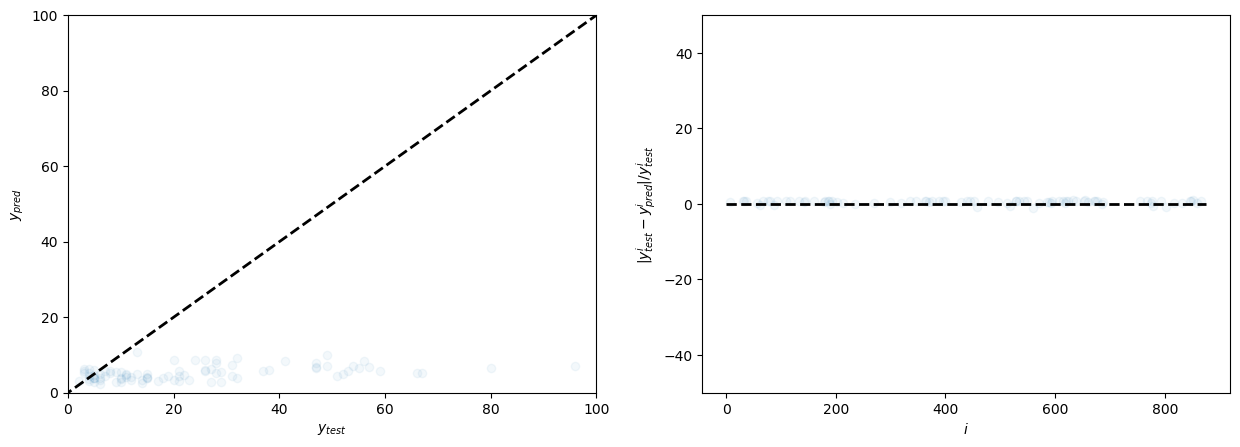

In [90]:
y_pred = ann.predict(X_test, batch_size=batch_size)
rel_res = (y_test.values-y_pred[:,0])/y_test.values

plot_idx = np.random.choice(range(len(y_test)), size=len(y_test)//10, replace=False)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,5), dpi=100)

ax[0].scatter(y_test.values[plot_idx], y_pred[:,0][plot_idx], alpha=0.05);
ax[0].set_xlabel('$y_{test}$')
ax[0].set_ylabel('$y_{pred}$')
ax[0].set_xlim(0,100)
ax[0].set_ylim(0,100)
ax[0].plot(range(-10,130), range(-10,130), '--k', lw=2);

ax[1].scatter(np.arange(len(rel_res))[plot_idx], rel_res[plot_idx], alpha=0.05);
ax[1].set_xlabel('$i$')
ax[1].set_ylabel('$|y_{test}^i-y_{pred}^i|/y_{test}^i$');
ax[1].plot(range(len(rel_res)), 0*np.arange(len(rel_res)), '--k', lw=2);
ax[1].set_ylim(-50,50);

# sns.kdeplot(y_test.values-y_pred[:,0], ax=ax[1], shade=True)
# ax[1].set_xlim(-50,50);

## Feature Importance

In [91]:
df_corr = train_dataset.corr()
feature_importances['Duration_Corr'] = df_corr['Duration'].abs().sort_values()[:-1]

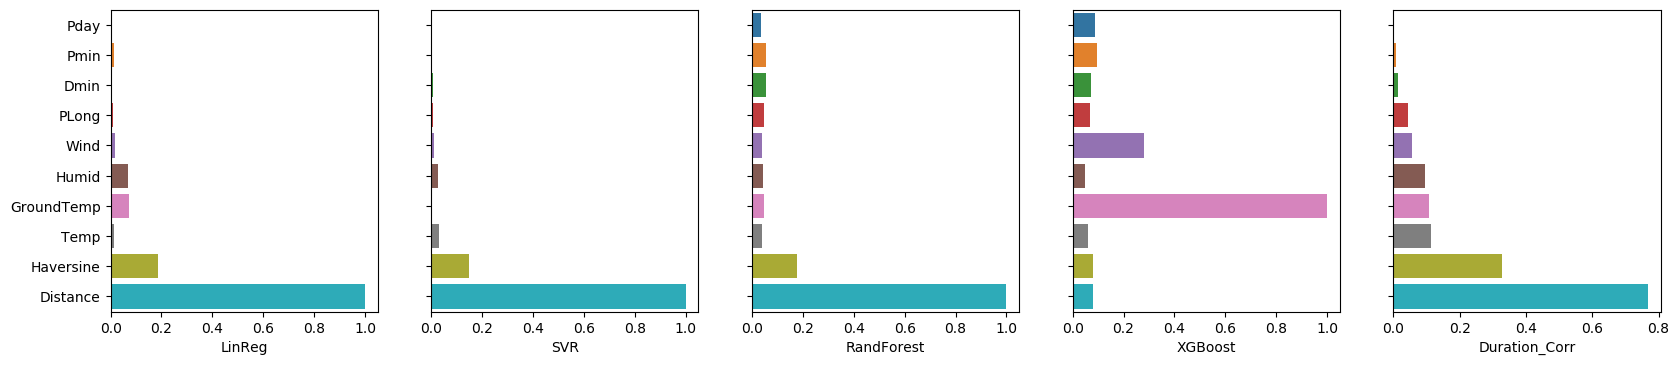

In [105]:
feature_importances = feature_importances.sort_values('Duration_Corr')

fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(20,4), dpi=100, sharey=True)

sns.barplot(y=feature_importances.index, x= feature_importances.LinReg, ax=ax[0])
sns.barplot(y=feature_importances.index, x= feature_importances.SVR, ax=ax[1])
sns.barplot(y=feature_importances.index, x= feature_importances.RandForest, ax=ax[2])
sns.barplot(y=feature_importances.index, x= feature_importances.XGBoost, ax=ax[3])
sns.barplot(y=feature_importances.index, x= feature_importances.Duration_Corr, ax=ax[4]);

### Hyperparameters Tuning